## **Project: Emotion Recognition and Generation**
**By: Ahmad Uzzam Masood**

---



Phases:
1. Emotion Recognition
2. Artificial Emotion Generation using self-made GAN
3. Artificial Emotion Generation using StyleGAN2 
4. DeepDream visualisation of ResNet50 used for Emotion Recognition
5. Feature Maps visualisation of ResNet50 used for Emotion Recognition

**First, we will use StyleGAN2 to generate images. Then we will detect emotions in these images.**

**Note: For Deep Dream, Target size has been changed to (1000, 1000) AFTER training the model.**

**A face is generated using a 512 number Latent Vector, which can be thought of as genes. The 'seed' used generates 512 random numbers for the Latent Vector.**

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importing/cloning nVidia's StyleGAN2 into this runtime.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (58/58), done.
     |████████████████████████████████| 108 kB 6.4 MB/s 


Listing the 'content' directory to ensure StyleGAN2 has been cloned.

In [ ]:
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


The expand_seed function takes the seed and expands it into 512 number vectors. The generate_images function is based on code found on the nVidia StyleGAN website. Truncation_psi is used for making the image clearer.

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed): #To convert the seed into the 512 Latent Vector
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):  #Displaying the generated image
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi): #G is the neural network, truncation_psi is used for noise clearance.
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...
(1, 512)


In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [2000,2003,2001]
STEPS = 200

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 2000:   0%|          | 0/200 [00:00<?, ?it/s]

Seed 2003:   0%|          | 0/200 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
from google.colab import files
files.download('movie.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/movie.mp4"

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# **Now we will train a resnet for emotion detection.**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/2013 dataset with 7 emotions.zip")

     |████████████████████████████████| 77 kB 3.5 MB/s 
patool: Extracting /content/2013 dataset with 7 emotions.zip ...
patool: running /usr/bin/7z x -o./Unpack_3z7v818b -- "/content/2013 dataset with 7 emotions.zip"
patool: ... /content/2013 dataset with 7 emotions.zip extracted to `2013 dataset with 7 emotions' (multiple files in root).


'2013 dataset with 7 emotions'

In [ ]:
train_dataset = train.flow_from_directory("/content/2013 dataset with 7 emotions/train", 
                                          target_size=(100,100),
                                          batch_size = 32,
                                          class_mode = 'categorical')

validation_dataset = train.flow_from_directory("/content/2013 dataset with 7 emotions/test", 
                                          target_size=(100,100),
                                          batch_size = 32,
                                          class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_dataset.class_indices
validation_dataset.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [ ]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    #Creating skip connection
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(1000, 1000, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = MaxPooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(7, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_res_net()

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 3)]                                                              
                                                                                                  
 batch_normalization_30 (BatchN  (None, 1000, 1000,   12         ['input_2[0][0]']                
 ormalization)                  3)                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 1000, 1000,   1792        ['batch_normalization_30[0][0]'] 
                                64)                                                        

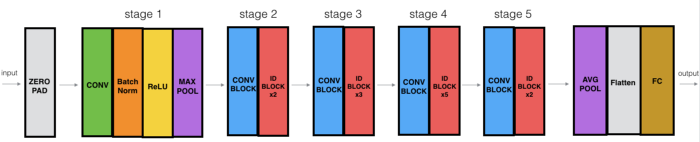

The ResNet-50 model consists of 5 stages each with a convolution and Identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. The ResNet-50 has over 23 million trainable parameters.

In [ ]:
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

#Creating checkpoints so that we can pick up training from where we left off
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.load_weights(latest)

model.fit(
    train_dataset,
    epochs=50,
    verbose=1,
    validation_data = validation_dataset,
    batch_size=20,
    callbacks=[cp_callback]
)

DataLossError: ignored

In [ ]:
# Now, look at the resulting checkpoints and choose the latest one:
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp.ckpt'

**After 50 epochs, the accuracy turns out to be 65.3%.**

In [ ]:
#Save the model
model.save('Model for Artifical Emotion Generation.h5') 


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#Import the model and show its architecture
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

In [ ]:
#Check the accuracy of imported model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [ ]:
test_path = "/content/results"

for i in os.listdir(test_path):
    img = image.load_img(test_path+'//'+i,target_size=(48,48,3))
    plt.imshow(img)
    plt.show()
    
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis=0)
    images = np.vstack([X])
    
    val = model.predict(images)
    print(val)


# **Deep Dream**

In [ ]:
import matplotlib as mpl

import IPython.display as display
import PIL.Image
import cv2
from PIL import Image

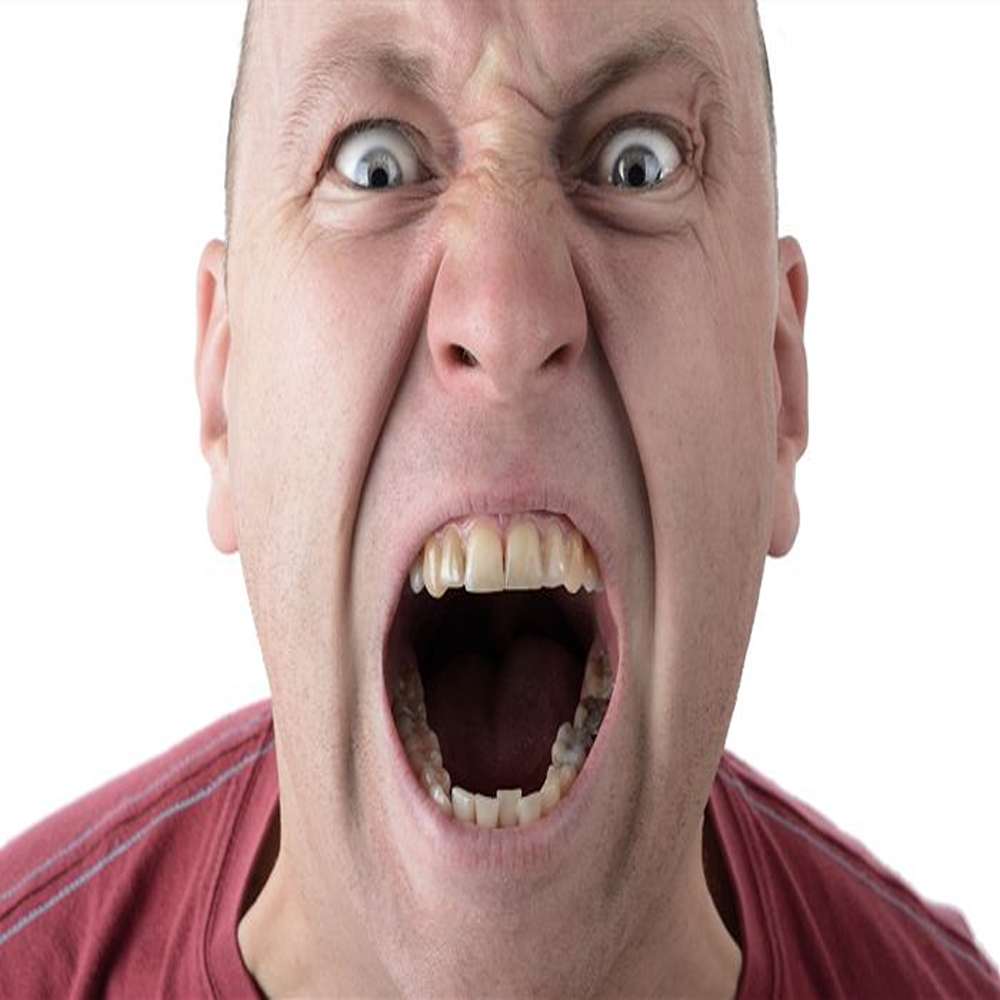

In [ ]:
# Read image into a NumPy array.
url = 'https://www.abc.net.au/reslib/201502/r1385324_19654578.jpg'
name = url.split('/')[-1]
image_path = tf.keras.utils.get_file(name, origin=url)
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
o_img = np.array(img)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

show(o_img)

In [ ]:
base_model = model

#Maximize the activations of these layers
names = ['conv2d_156', 'conv2d_157']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

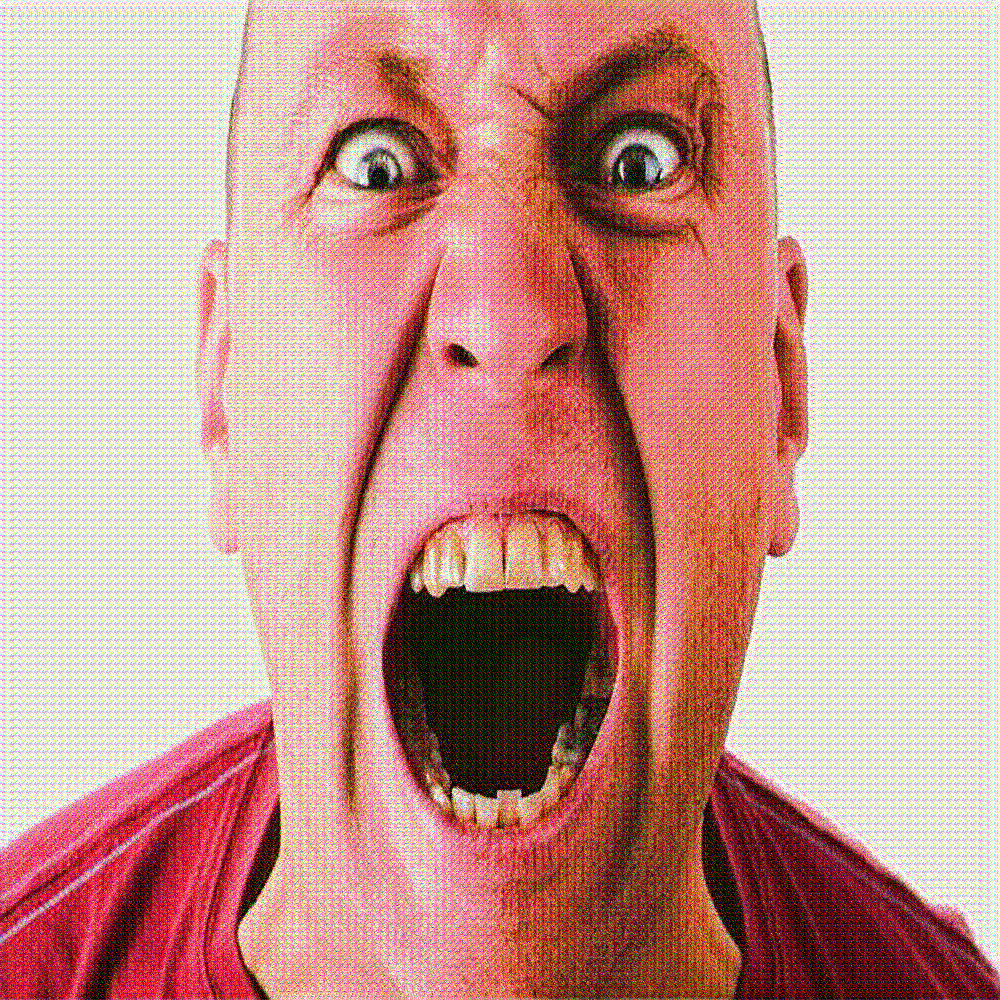

In [ ]:
dream_img = run_deep_dream_simple(img=o_img, 
                                  steps=100, step_size=0.01)

In [ ]:
#pick a layer for visualization 
viz_act_layer = vgg.conv2d_156

# store the activations of the conv5_3 layer
def layer_activations(img,layer):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        activations = sess.run([layer], feed_dict={vgg.imgs:img.reshape([–1,224,224,3])})
        activations = np.array(activations).squeeze()
    return activations

conv_activations = layer_activations(org_img,viz_act_layer)

SyntaxError: ignored

# **Feature map of first hidden layer**

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 batch_normalization (BatchN  (None, 1000, 1000, 3)    12        
 ormalization)                                                   
                                                                 
Total params: 12
Trainable params: 6
Non-trainable params: 6
_________________________________________________________________


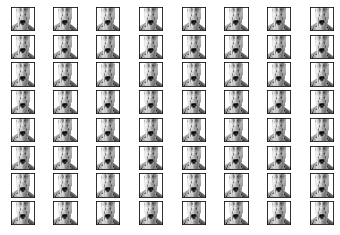

<Figure size 3600x3600 with 0 Axes>

In [ ]:

# plot feature map of first conv layer for given image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, 2], cmap='gray')
		ix += 1
# show the figure
from matplotlib.pyplot import figure

pyplot.figure(figsize=(50, 50))
pyplot.show()

In [ ]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_32 (3, 3, 3, 64)
conv2d_33 (3, 3, 64, 64)
conv2d_34 (3, 3, 64, 64)
conv2d_35 (3, 3, 64, 64)
conv2d_36 (3, 3, 64, 64)
conv2d_37 (3, 3, 64, 128)
conv2d_39 (1, 1, 64, 128)
conv2d_38 (3, 3, 128, 128)
conv2d_40 (3, 3, 128, 128)
conv2d_41 (3, 3, 128, 128)
conv2d_42 (3, 3, 128, 128)
conv2d_43 (3, 3, 128, 128)
conv2d_44 (3, 3, 128, 128)
conv2d_45 (3, 3, 128, 128)
conv2d_46 (3, 3, 128, 128)
conv2d_47 (3, 3, 128, 128)
conv2d_48 (3, 3, 128, 256)
conv2d_50 (1, 1, 128, 256)
conv2d_49 (3, 3, 256, 256)
conv2d_51 (3, 3, 256, 256)
conv2d_52 (3, 3, 256, 256)
conv2d_53 (3, 3, 256, 256)
conv2d_54 (3, 3, 256, 256)
conv2d_55 (3, 3, 256, 256)
conv2d_56 (3, 3, 256, 256)
conv2d_57 (3, 3, 256, 256)
conv2d_58 (3, 3, 256, 256)
conv2d_59 (3, 3, 256, 512)
conv2d_61 (1, 1, 256, 512)
conv2d_60 (3, 3, 512, 512)
conv2d_62 (3, 3, 512, 512)
conv2d_63 (3, 3, 512, 512)


# **Feature maps output from first four blocks**

In [ ]:
ixs = [2, 5, 9, 13, 14]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 3)]                                                              
                                                                                                  
 batch_normalization_30 (BatchN  (None, 1000, 1000,   12         ['input_2[0][0]']                
 ormalization)                  3)                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 1000, 1000,   1792        ['batch_normalization_30[0][0]'] 
                                64)                                                        

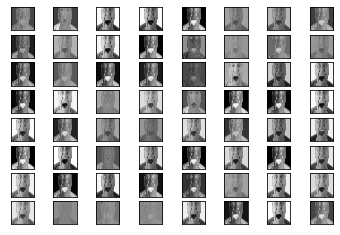

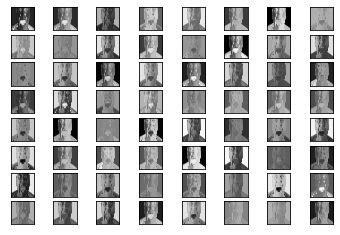

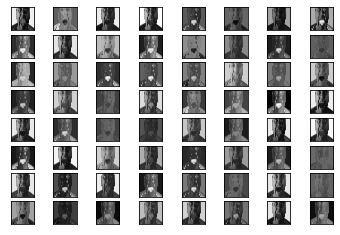

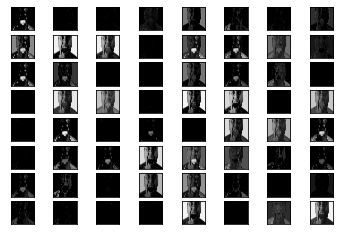

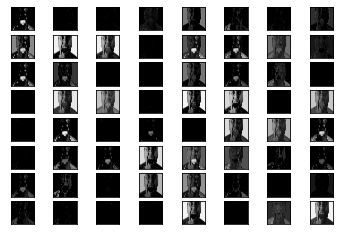

In [ ]:
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()